<a href="https://colab.research.google.com/github/titocampos/estudo-crm/blob/master/Tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Sources</b>
  - https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/?__s=uwyrtqrb1sbk1eht5hsk
  - https://medium.com/towards-artificial-intelligence/using-tesseract-ocr-for-text-recognition-with-google-colab-1c4513b9d3e0
  - https://nanonets.com/blog/ocr-with-tesseract/



In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!which tesseract
!md images
!cd images 


In [ ]:
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/ANA-1322.jpg
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/image.png
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/page.jpg
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/images/receipt.jpg

In [115]:
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
from scipy.spatial import ConvexHull
import pytesseract


Procedures

In [89]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect


def four_point_transform(image, pts):
  # obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped


def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

 
def minimum_bounding_rectangle(points):
    """
    https://gis.stackexchange.com/questions/22895/finding-minimum-area-rectangle-for-given-points
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2), dtype="int")
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval 


DrawBox


In [ ]:
args={}
args['image'] = './images/ANA-1322.jpg'
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
_, axs = plt.subplots(1, 3, figsize=(20, 15))
axs = axs.flatten()
for img, ax in zip([image, gray,edged], axs):
    ax.imshow(img)
plt.show()


In [ ]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
  # approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  #corners = order_points(approx)
  #print (approx)

  # if our approximated contour has four points, then we
  # can assume that we have found our screen
  cv2.drawContours(image, [approx], -1, (255, 0, 0), 3)
  _ , axs = plt.subplots(1, 1, figsize=(12, 8))
  axs.imshow(image)
  break

Scanner

STEP 1: Edge Detection


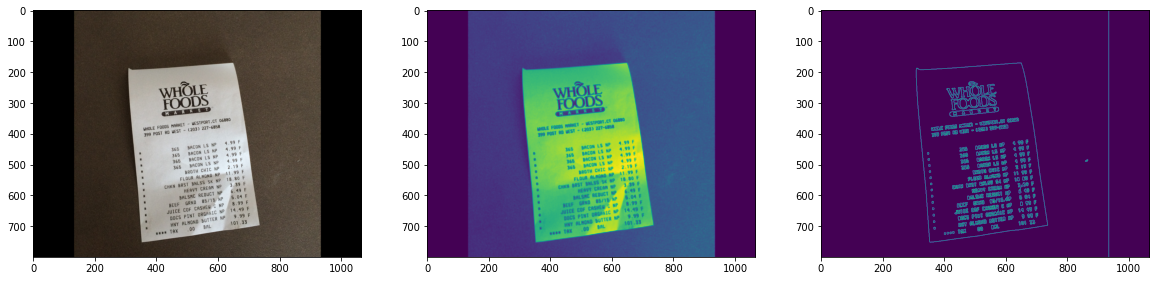

In [170]:
args={}
args['image'] = 'images/receipt.jpg'

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
image = imutils.rotate(image, 90)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ratio = image.shape[0] / 800.0
orig = image.copy()
image = imutils.resize(image, height = 800)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
print("STEP 1: Edge Detection")
_, axs = plt.subplots(1, 3, figsize=(20, 15))
axs = axs.flatten()
for img, ax in zip([image, gray, edged], axs):
    ax.imshow(img)
plt.show()


STEP 2: Find contours of paper


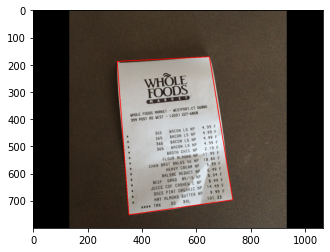

In [171]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (255, 0, 0), 2)
plt.figsize=(20, 15)
plt.imshow(image)



STEP 3: Apply perspective transform


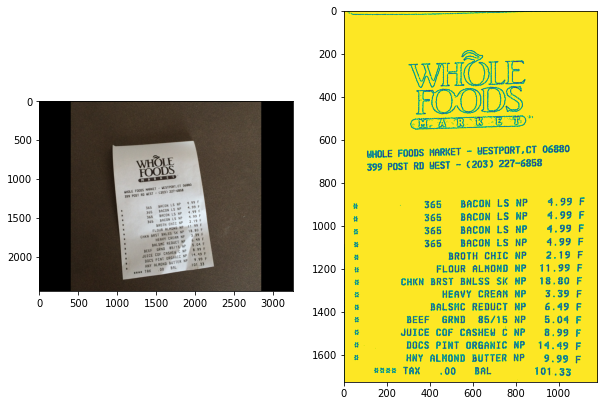

In [172]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# show the original and scanned images
print("STEP 3: Apply perspective transform")
_, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip([orig, warped], axs):
    ax.imshow(img)
plt.show()

Tesseract

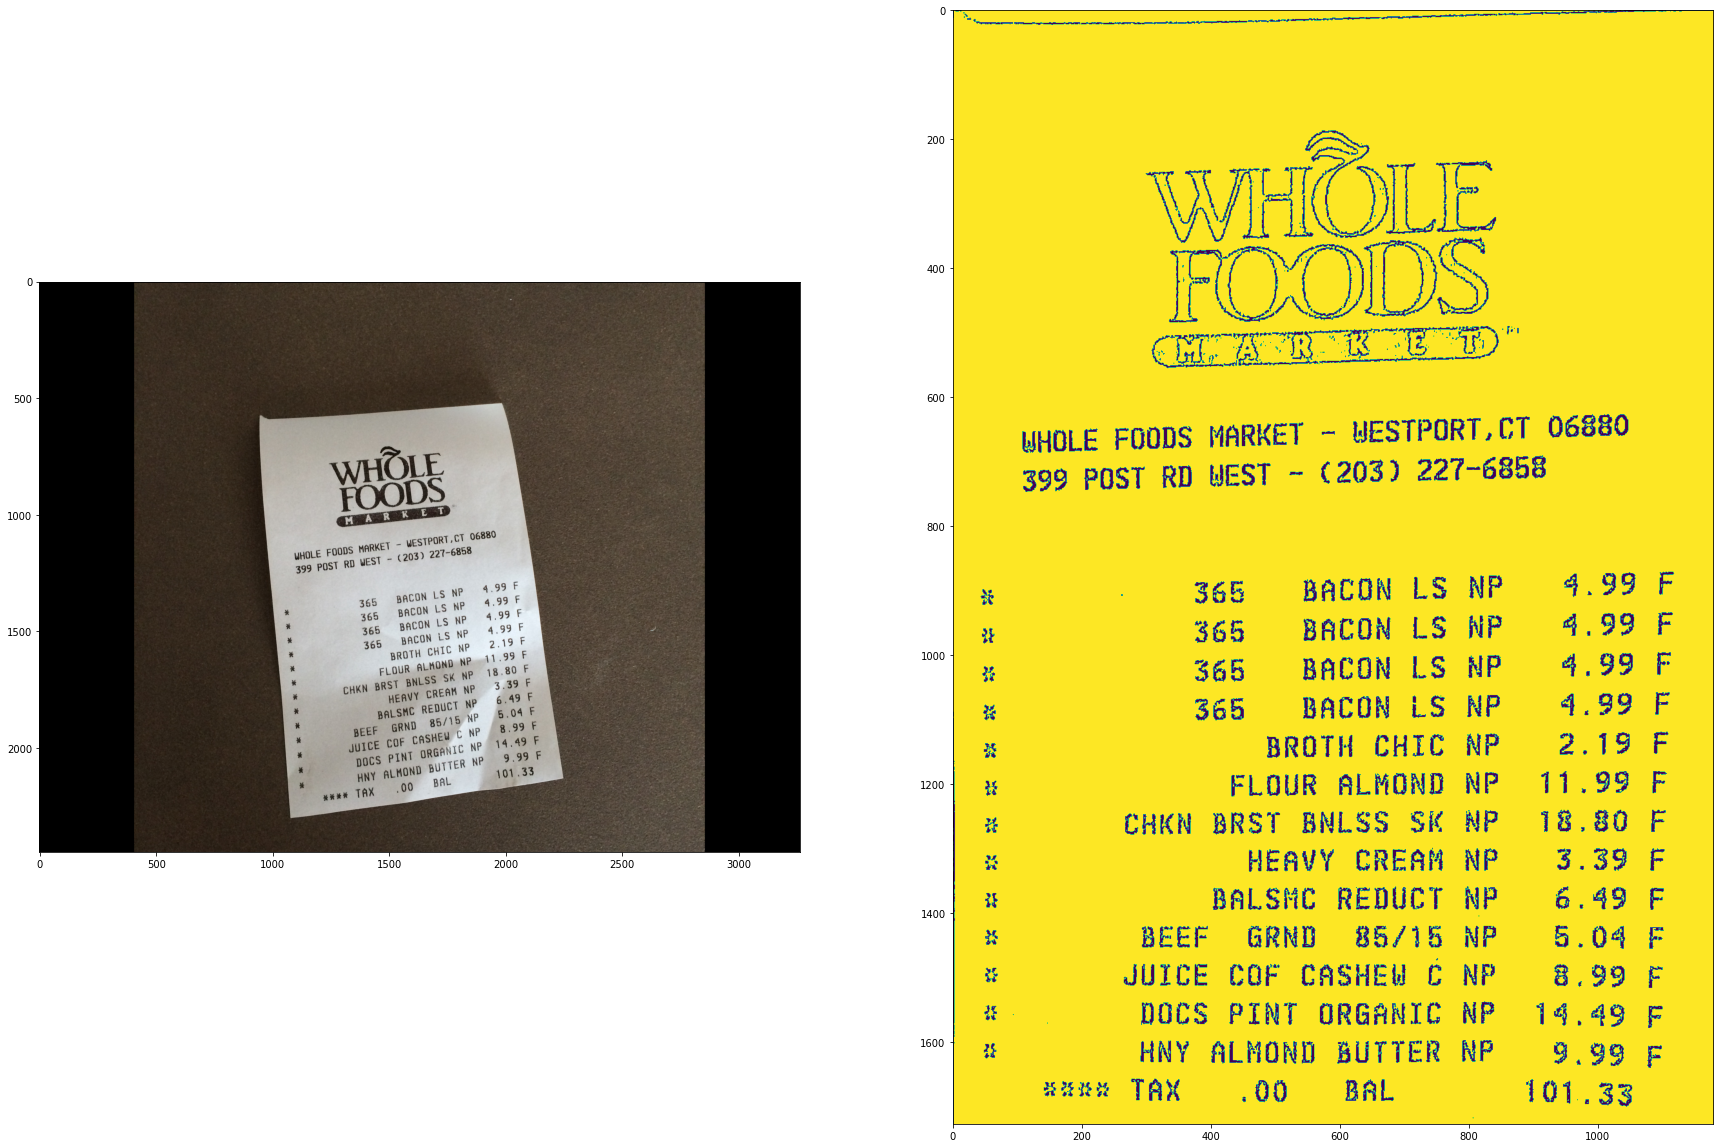

In [176]:
edge = warped.copy()
thresh = cv2.threshold(edge, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

_, axs = plt.subplots(1, 2, figsize=(30, 30))
axs = axs.flatten()
for img, ax in zip([orig, thresh], axs):
    ax.imshow(img)
plt.show()


In [177]:
#by using print we avoid a single string containing various /n
print(pytesseract.image_to_string(thresh, lang='eng', config='--psm 6'))

WALI \ as

WHOLE

FOODS

I nw, bo)

Cake
WHOLE FOODS MARKET - WESTPORT,CT 06880
399 POST RD WEST ~ (203) 227-6858
% 365 BACON LS NP 4.99 F
3 365 BACON LS NP 4.99 F
zt 365 BACON LS NP 4.99 F
x 365 BACON LS NP 4.99 F
2 BROTH CHIC NP 2.19 F
tt FLOUR ALMOND NP 11.99 F
# CHKN BRST BNLSS SK NP 18.80 F
x HEAVY CREAM NP 3.39 F
3 BALSNC REDUCT NP 6.49 F
i BEEF GRND 85/15 NP 5.04 F
JUICE COF CASHEW C NP 8.99 F
tt DOCS PINT ORGANIC NP 14,49 F
tt HNY ALMOND BUTTER NP 9.99 f£
wun TAX 00 BAL 101.33
